In [1]:
# Code from https://towardsdatascience.com/classifying-the-proteins-benchmark-dataset-ec18e728a17a

# Cannot extract features? https://github.com/tensorflow/tensorflow/issues/48196


## TODO later
- do the pytorch_geometric version

## Imports

In [2]:
from spektral.datasets import TUDataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from spektral.layers import GCNConv, GlobalSumPool
from spektral.transforms import GCNFilter
import numpy as np
from spektral.data import BatchLoader
import tensorflow as tf
from matplotlib import pyplot as plt

## Set Eager Execution

In [3]:
tf.config.run_functions_eagerly(False)

## Import dataset

In [4]:
# Spectral provides the TUDataset class, which contains benchmark datasets for graph classification
data = TUDataset('PROTEINS')
# Since we want to utilize the Spektral GCN layer, we want to follow the original paper for this method and perform some preprocessing:
data.apply(GCNFilter())

Successfully loaded PROTEINS.


# Split datasets

In [5]:
data_split = 0.8

# Shuffle the data
np.random.shuffle(data)
split = int(data_split * len(data))
data_train, data_test = data[:split], data[split:]

# Report stats
print(f"Number of graphs: {data.n_graphs}")
print("Train-test split:  ", data_split)
print(f"Number of training samples: {data_train.n_graphs}")
print(f"Number of testing samples:  {data_test.n_graphs}")

Number of graphs: 1113
Train-test split:   0.8
Number of training samples: 890
Number of testing samples:  223


# Create Datasets

In [6]:
# Here's the trick - we can't just call Keras' fit() method on this model.
# Instead, we have to use Loaders, which Spektral walks us through. Loaders create mini-batches by iterating over the graph
# Since we're using Spektral for an experiment, for our first trial we'll use the recommended loader in the getting started tutorial
train_loader = BatchLoader(data_train, batch_size=32)
test_loader = BatchLoader(data_test, batch_size=32)

## Define the model

In [7]:
class ProteinsGNN(Model):
    def __init__(self, n_hidden, n_labels):
        super().__init__()
        # Define our GCN layer with our n_hidden layers
        self.graph_conv = GCNConv(n_hidden)
        # Define our global pooling layer
        self.pool = GlobalSumPool()
        # Define our dropout layer
        self.dropout = Dropout(0.2)
        # Define our Dense layer, with softmax activation function
        self.dense = Dense(n_labels, 'softmax')
    
    # Define class method to call model on input
    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

    def embed(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

    
    def build_graph(self):
        x1 = Input(shape=(162, 4))
        x2 = Input(shape=(162, 162))
        return Model(inputs=[x1, x2], outputs=self.call([x1, x2]))


# Define the model

In [8]:
# Instantiate our model for training
model = ProteinsGNN(32, data.n_labels)


# Compile model with our optimizer (adam) and loss function
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics='accuracy')

# Visualize model
print(model.build_graph().summary())

2021-10-27 11:50:05.042290: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-27 11:50:05.042369: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kontor
2021-10-27 11:50:05.042376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kontor
2021-10-27 11:50:05.042677: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-10-27 11:50:05.042720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-10-27 11:50:05.042726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2021-10-27 11:50:05.043120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 162, 4)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 162, 162)]   0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 162, 32)      160         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 162, 32)      0           gcn_conv[0][0]               

## Train

In [9]:
model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, epochs=20)

Epoch 1/20


2021-10-27 11:50:05.834709: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


28/28 [==============================] - 1s 12ms/step - loss: 9.4149 - accuracy: 0.5528
Epoch 2/20
28/28 [==============================] - 0s 12ms/step - loss: 5.2134 - accuracy: 0.6045
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 4.9051 - accuracy: 0.5730
Epoch 4/20
28/28 [==============================] - 0s 11ms/step - loss: 4.8003 - accuracy: 0.5955
Epoch 5/20
28/28 [==============================] - 0s 11ms/step - loss: 5.4953 - accuracy: 0.5787
Epoch 6/20
28/28 [==============================] - 0s 10ms/step - loss: 4.1261 - accuracy: 0.5888
Epoch 7/20
28/28 [==============================] - 0s 11ms/step - loss: 3.9235 - accuracy: 0.6494
Epoch 8/20
28/28 [==============================] - 0s 12ms/step - loss: 4.4289 - accuracy: 0.5843
Epoch 9/20
28/28 [==============================] - 0s 10ms/step - loss: 4.5951 - accuracy: 0.5719
Epoch 10/20
28/28 [==============================] - 0s 11ms/step - loss: 4.7595 - accuracy: 0.6011
Epoch 11/20
28/28 [=

## Evaluate

In [10]:
loss, acc = model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print('Test loss: {}'.format(loss))
print('Test acc:  {}'.format(acc))

7/7 [==============================] - 0s 6ms/step - loss: 4.7752 - accuracy: 0.5605
Test loss: 4.775246620178223
Test acc:  0.560538113117218


# Plot model predictions (cannot access intermedeate layers)

### Obtain the list of labels

In [11]:
labels = [np.argmax(d.y) for d in data]

### Prepare dataset for all the data

In [12]:
data_loader = BatchLoader(data, batch_size=32)

## Plot

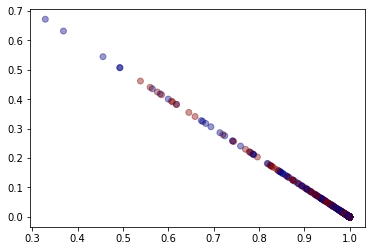

In [13]:
predictions = model.predict(data_loader.load(), steps=data_loader.steps_per_epoch)
plt.scatter(predictions[:, 0], predictions[:, 1], c=labels, cmap="jet", alpha=0.4)